In [1]:
!pip install chart_studio

In [2]:
import types
import pandas as pd
import sklearn as sk
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
# import chart_studio.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go
df = pd.read_csv('/project_data/data_asset/bq-results-20200505-181914-yglz5y8jrefn.csv')

#inititate Plotly
# pyoff.init_notebook_mode()
pd.options.mode.chained_assignment = None


print(df.dtypes)
print(df.head(5))

COMP_CODE              int64
CUSTOMER               int64
FISCPER                int64
DOC_NUMBER             int64
LINE_ITEM              int64
SUB_ITEM               int64
DOC_TYPE              object
POSTING_DATE          object
DOC_DATE              object
NETDUE_DATE           object
CLEAR_DATE            object
CUST_CRE_REP_GRP      object
LOCAL_CURRENCY        object
AMOUNT               float64
ITEM_STATUS           object
PAYMENT_TERMS         object
GL_ACCOUNT            object
__index_level_0__      int64
CustomerId             int64
CustomerNm            object
custcounty            object
state_code            object
State                 object
dtype: object
   COMP_CODE  CUSTOMER  FISCPER  DOC_NUMBER  LINE_ITEM  SUB_ITEM DOC_TYPE  \
0       1000    232752  2019001  9028989092          1         1       ZA   
1       1000    232752  2019002  9030204614          1         1       ZA   
2       1000    232752  2019002  9030165168          1         1       ZA   
3       100

In [3]:
# Change order date to datetime

df['DOC_DATE'] = df['DOC_DATE'].astype(dtype='datetime64[ns]')
print(df.dtypes)
print(df.shape)

##### RFM Feature engineering #####

# Get only rows with a valid sales price value
df = df.query('AMOUNT != 0')
print(df.shape)

# Drop dupes
df = df.drop_duplicates()
print(df.shape)

COMP_CODE                     int64
CUSTOMER                      int64
FISCPER                       int64
DOC_NUMBER                    int64
LINE_ITEM                     int64
SUB_ITEM                      int64
DOC_TYPE                     object
POSTING_DATE                 object
DOC_DATE             datetime64[ns]
NETDUE_DATE                  object
CLEAR_DATE                   object
CUST_CRE_REP_GRP             object
LOCAL_CURRENCY               object
AMOUNT                      float64
ITEM_STATUS                  object
PAYMENT_TERMS                object
GL_ACCOUNT                   object
__index_level_0__             int64
CustomerId                    int64
CustomerNm                   object
custcounty                   object
state_code                   object
State                        object
dtype: object
(861327, 23)
(861238, 23)
(861238, 23)


In [7]:
### Recency ###

# Create df with unique customer IDs
df_cust = pd.DataFrame(df['CUSTOMER'].unique())
df_cust.columns = ['CUSTOMER']
print(df_cust)

    CUSTOMER
0     232752
1     101113
2     101037
3     101374
4     101128
5     101301
6       8000
7       8054
8       8222
9       8042
10      8078
11    227344
12    227343
13    227356
14    227354
15    101307
16    242721
17    100065
18    100063
19    189565


In [8]:
# Get the most recent date for each customer in seperate df
df_mp = df.groupby('CUSTOMER').DOC_DATE.max().reset_index()
df_mp.columns = ['CUSTOMER','MostRecent']
print(df_mp)

    CUSTOMER MostRecent
0       8000 2019-11-30
1       8042 2019-11-30
2       8054 2019-11-30
3       8078 2019-11-30
4       8222 2019-11-30
5     100063 2019-11-30
6     100065 2019-11-27
7     101037 2018-06-27
8     101113 2019-11-30
9     101128 2019-11-30
10    101301 2019-11-30
11    101307 2019-11-30
12    101374 2019-11-30
13    189565 2019-11-30
14    227343 2019-11-30
15    227344 2019-05-29
16    227354 2019-11-30
17    227356 2019-11-30
18    232752 2019-11-30
19    242721 2019-11-30


In [9]:
# Take most recent date in dataset to find recency for each observation
df_mp['Recency'] = (df_mp['MostRecent'].max() - df_mp['MostRecent']).dt.days

# Merge dataframes
df_cust = pd.merge(df_cust, df_mp[['CUSTOMER','Recency']], on='CUSTOMER')

df_cust.head()

,CUSTOMER,Recency
0,232752,0
1,101113,0
2,101037,521
3,101374,0
4,101128,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaa299b940>]],
      dtype=object)

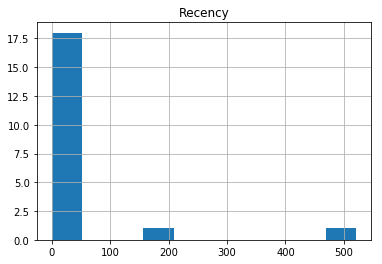

In [10]:
# Recency histogram
df_cust.hist(column='Recency')

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/s

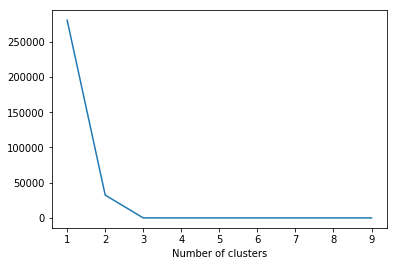

In [11]:
# Find optimal clusters for Recency score, using elbow method
from sklearn.cluster import KMeans

sse={}
df_recency = df_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [12]:
# Build 3 clusters (elbow method) for Recency and add it to df
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cust[['Recency']])
df_cust['RecencyCluster'] = kmeans.predict(df_cust[['Recency']])

# Function for ordering cluster numbers (0 cluster number is low recency, 2 is high recency)
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    #new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name ,ascending = ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns = {"index":cluster_field_name})
    return df_final

df_cust = order_cluster('RecencyCluster', 'Recency', df_cust, False)
# print(df_cust)
df_cust.describe()
# Summary about Recency Clusters
#df_cust.groupby('RecencyCluster')['Recency'].describe()

,CUSTOMER,Recency,RecencyCluster
count,20.000000,20.000000,20.00000
mean,121110.950000,35.450000,1.85000
std,87126.111833,121.512605,0.48936
min,8000.000000,0.000000,0.00000
25%,77102.750000,0.000000,2.00000
50%,101214.500000,0.000000,2.00000
75%,227343.250000,0.000000,2.00000
max,242721.000000,521.000000,2.00000


In [13]:
### Frequency ###

# Order counts per customer
df_freq = df.groupby('CUSTOMER').DOC_DATE.count().reset_index()
df_freq.columns = ['CUSTOMER','Frequency']
print(df_freq)

# Add to main df
df_cust = pd.merge(df_cust, df_freq, on='CUSTOMER')
print(df_cust)

    CUSTOMER  Frequency
0       8000      17211
1       8042      60567
2       8054      17432
3       8078      45678
4       8222      17178
5     100063       1151
6     100065        870
7     101037      26831
8     101113      26464
9     101128      59205
10    101301       5664
11    101307      13743
12    101374     243092
13    189565        737
14    227343      49193
15    227344     103435
16    227354      22771
17    227356     130674
18    232752      16380
19    242721       2962
    CUSTOMER  Recency  RecencyCluster  Frequency
0     232752        0               2      16380
1     101113        0               2      26464
2     101374        0               2     243092
3     101128        0               2      59205
4     101301        0               2       5664
5       8000        0               2      17211
6       8054        0               2      17432
7       8222        0               2      17178
8       8042        0               2      60567
9     

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaa28de048>]],
      dtype=object)

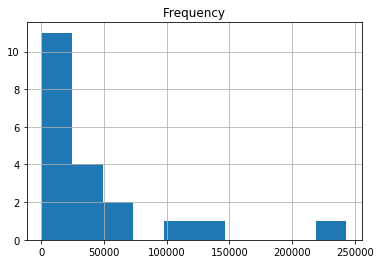

In [14]:
# Frequency histogram
df_cust.hist(column='Frequency')

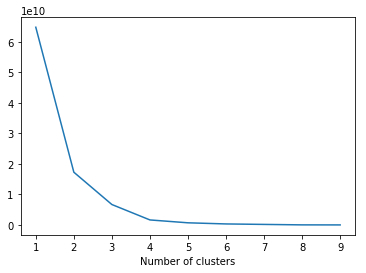

In [15]:
# Find number of clusters for Frequency
sse={}
df_frequency = df_cust[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_frequency)
    df_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [16]:
# Build 3 clusters (elbow method) for Frequency and add it to df
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cust[['Frequency']])
df_cust['FrequencyCluster'] = kmeans.predict(df_cust[['Frequency']])

# Order Frequency clusters
df_cust = order_cluster('FrequencyCluster', 'Frequency', df_cust, True)
print(df_cust)

# Summary about Frequency Clusters
#df_cust.groupby('FrequencyCluster')['Frequency'].describe()
df_cust.describe()

    CUSTOMER  Recency  RecencyCluster  Frequency  FrequencyCluster
0     232752        0               2      16380                 0
1     101113        0               2      26464                 0
2     101128        0               2      59205                 0
3     101301        0               2       5664                 0
4       8000        0               2      17211                 0
5       8054        0               2      17432                 0
6       8222        0               2      17178                 0
7       8042        0               2      60567                 0
8       8078        0               2      45678                 0
9     227343        0               2      49193                 0
10    227354        0               2      22771                 0
11    101307        0               2      13743                 0
12    242721        0               2       2962                 0
13    100065        3               2        870              

,CUSTOMER,Recency,RecencyCluster,Frequency,FrequencyCluster
count,20.000000,20.000000,20.00000,20.000000,20.000000
mean,121110.950000,35.450000,1.85000,43061.900000,0.200000
std,87126.111833,121.512605,0.48936,58398.039155,0.523148
min,8000.000000,0.000000,0.00000,737.000000,0.000000
25%,77102.750000,0.000000,2.00000,11723.250000,0.000000
50%,101214.500000,0.000000,2.00000,20101.500000,0.000000
75%,227343.250000,0.000000,2.00000,51696.000000,0.000000
max,242721.000000,521.000000,2.00000,243092.000000,2.000000


In [17]:
### Revenue ###

# Find revenue for each customer
df['Revenue'] = df['AMOUNT']
df_rev = df.groupby('CUSTOMER').Revenue.sum().reset_index()

# Add to main df
df_cust = pd.merge(df_cust, df_rev, on='CUSTOMER')
print(df_cust)

    CUSTOMER  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     232752        0               2      16380                 0   
1     101113        0               2      26464                 0   
2     101128        0               2      59205                 0   
3     101301        0               2       5664                 0   
4       8000        0               2      17211                 0   
5       8054        0               2      17432                 0   
6       8222        0               2      17178                 0   
7       8042        0               2      60567                 0   
8       8078        0               2      45678                 0   
9     227343        0               2      49193                 0   
10    227354        0               2      22771                 0   
11    101307        0               2      13743                 0   
12    242721        0               2       2962                 0   
13    100065        

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa985a7e10>]],
      dtype=object)

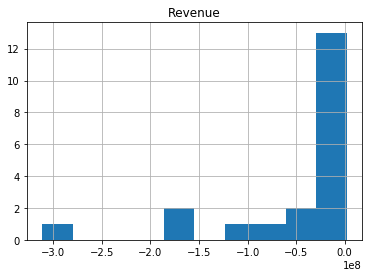

In [18]:
# Monetary Value histogram
df_cust.hist(column='Revenue')

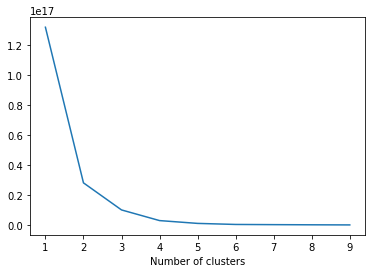

In [19]:
# Find number of clusters for Revenue
sse = {}
df_revenue = df_cust[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [20]:
# Build 3 clusters (elbow method) for Revenue and add it to df
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_cust[['Revenue']])
df_cust['RevenueCluster'] = kmeans.predict(df_cust[['Revenue']])

# Order Frequency clusters
df_cust = order_cluster('RevenueCluster', 'Revenue', df_cust, True)
print(df_cust)

# Summary about Frequency Clusters
#df_cust.groupby('RevenueCluster')['Revenue'].describe()
df_cust.describe()

    CUSTOMER  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     232752        0               2      16380                 0   
1     101113        0               2      26464                 0   
2       8000        0               2      17211                 0   
3       8054        0               2      17432                 0   
4       8222        0               2      17178                 0   
5       8042        0               2      60567                 0   
6       8078        0               2      45678                 0   
7     227343        0               2      49193                 0   
8     227354        0               2      22771                 0   
9     242721        0               2       2962                 0   
10    100065        3               2        870                 0   
11    100063        0               2       1151                 0   
12    189565        0               2        737                 0   
13    101037      52

,CUSTOMER,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
count,20.000000,20.000000,20.00000,20.000000,20.000000,2.000000e+01,20.00000
mean,121110.950000,35.450000,1.85000,43061.900000,0.200000,-4.824373e+07,1.75000
std,87126.111833,121.512605,0.48936,58398.039155,0.523148,8.327341e+07,0.55012
min,8000.000000,0.000000,0.00000,737.000000,0.000000,-3.115165e+08,0.00000
25%,77102.750000,0.000000,2.00000,11723.250000,0.000000,-5.739037e+07,2.00000
50%,101214.500000,0.000000,2.00000,20101.500000,0.000000,-4.356739e+06,2.00000
75%,227343.250000,0.000000,2.00000,51696.000000,0.000000,3.106418e+05,2.00000
max,242721.000000,521.000000,2.00000,243092.000000,2.000000,1.929152e+06,2.00000


In [21]:
# Get Overall Score and look at mean
df_cust['OverallScore'] = df_cust['RecencyCluster'] + df_cust['FrequencyCluster'] + df_cust['RevenueCluster']
RFM = ['Recency','Frequency','Revenue']
df_cust.groupby('OverallScore')[RFM].mean()

,Recency,Frequency,Revenue
OverallScore,,,
2,260.500000,43018.000000,-1.593685e+08
3,0.000000,9703.500000,-1.428669e+08
4,13.428571,27287.785714,-1.344578e+07
5,0.000000,186883.000000,-8.608149e+07


In [22]:
# Name buckets
df_cust['Segment'] = 'Low-Value'
df_cust.loc[df_cust['OverallScore']>=2,'Segment'] = 'Mid-Value' 
df_cust.loc[df_cust['OverallScore']>=4,'Segment'] = 'High-Value'
print(df_cust['Segment'].value_counts())

High-Value    16
Mid-Value      4
Name: Segment, dtype: int64
